Fanout list:
NAND2_1 - NAND2_5
NAND2_2 - NAND2_3, NAND2_4
NAND2_3 - NAND2_5, NAND2_6
NAND2_4 - NAND2_6
NAND2_5 - NO FANOUTS
NAND2_6 - NO FANOUTS

Correct longest path by logic depth:
NAND2_2 -> NAND2_3 -> NAND2_5

Number of gates in the longest path: 3


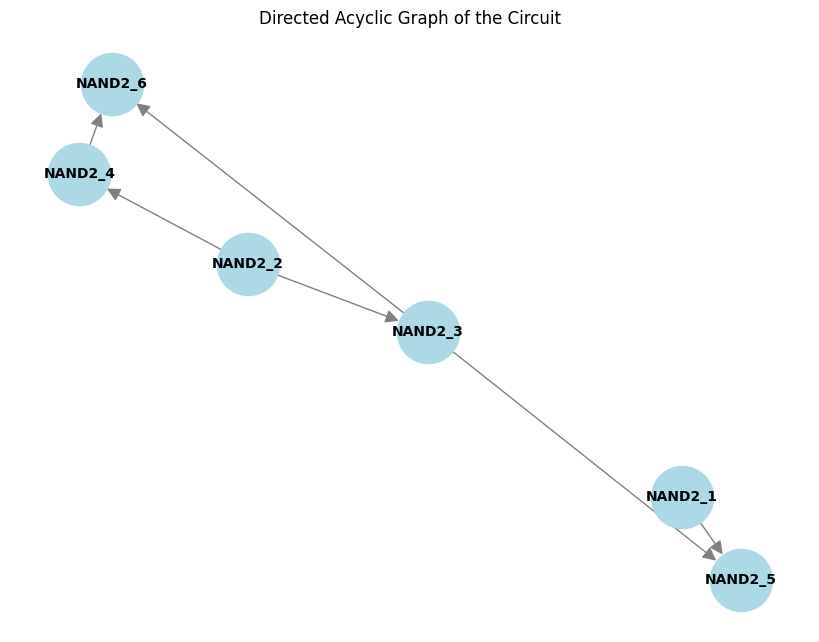

In [11]:
import networkx as nx
import re
import matplotlib.pyplot as plt

def parse_verilog(filename):
    graph = nx.DiGraph()
    fanout = {}
    gate_outputs = {}  # Maps output signals to gate instances
    gate_inputs = {}  # Maps gate instances to their inputs

    with open(filename, 'r') as f:
        lines = f.readlines()

    gate_regex = re.compile(r'(nand|nor|not)\s+(\w+)\s*\(([^)]+)\);')

    for line in lines:
        match = gate_regex.search(line)
        if match:
            gate_type, inst_name, ports = match.groups()
            ports = [p.strip() for p in ports.split(',')]

            output = ports[0]
            inputs = ports[1:]

            graph.add_node(inst_name, type=gate_type)
            gate_outputs[output] = inst_name  # Store which gate produces this output
            gate_inputs[inst_name] = inputs  # Store the inputs of this gate
            fanout[inst_name] = []  # Initialize fanout list

    # Build fanout list correctly
    for gate, inputs in gate_inputs.items():
        for inp in inputs:
            if inp in gate_outputs:  # If the input is generated by another gate
                driving_gate = gate_outputs[inp]
                fanout[driving_gate].append(gate)
                graph.add_edge(driving_gate, gate)  # Add edge for longest path analysis

    return graph, fanout

def topological_sort(graph):
    return list(nx.topological_sort(graph))

def find_correct_longest_path(graph):
    try:
        top_order = topological_sort(graph)
        dist = {node: float('-inf') for node in graph.nodes}
        prev = {node: None for node in graph.nodes}

        # Identify primary inputs (nodes with no predecessors)
        primary_inputs = [node for node in graph.nodes if graph.in_degree(node) == 0]
        for node in primary_inputs:
            dist[node] = 0

        # Compute longest paths using topological order
        for node in top_order:
            for successor in graph.successors(node):
                if dist[successor] < dist[node] + 1:
                    dist[successor] = dist[node] + 1
                    prev[successor] = node

        # Identify primary outputs (nodes with no successors)
        primary_outputs = [node for node in graph.nodes if graph.out_degree(node) == 0]

        # Find the farthest output node
        end_node = max(primary_outputs, key=lambda n: dist[n], default=None)

        # Reconstruct the longest path
        longest_path = []
        while end_node is not None:
            longest_path.append(end_node)
            end_node = prev[end_node]

        longest_path.reverse()
        return longest_path, len(longest_path)
    except nx.NetworkXUnfeasible:
        return [], 0

def plot_graph(graph):
    plt.figure(figsize=(8, 6))  # Adjust figure size

    pos = nx.spring_layout(graph, seed=42)  # Layout for better visualization
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", font_size=10, font_weight="bold", arrowsize=20)

    plt.title("Directed Acyclic Graph of the Circuit")
    plt.show()

def main():
    filename = "c17.txt"  # Change this to the correct file path
    graph, fanout = parse_verilog(filename)

    print("Fanout list:")
    for gate, fo in fanout.items():
        if fo:
            print(f"{gate} - {', '.join(fo)}")
        else:
            print(f"{gate} - NO FANOUTS")

    longest_path, max_length = find_correct_longest_path(graph)
    print("\nCorrect longest path by logic depth:")
    print(" -> ".join(longest_path))
    print(f"\nNumber of gates in the longest path: {max_length}")

    # Plot the DAG
    plot_graph(graph)


if __name__ == "__main__":
    main()
